In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 691.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=1e1786a21339d054a35928745c8c2b109ce7c86f3e1c7b2a71850690d4670122
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, GlobalAveragePooling2D, Multiply, Dense, Reshape, BatchNormalization, LSTM, Concatenate
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
#if not (os.path.isfile('Indian_pines_corrected.mat')):
#  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
#if not (os.path.isfile('Indian_pines_gt.mat')):
#  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_folder = '/content/drive/MyDrive/yapayZekaSistemleri/dataset'
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_folder, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_folder, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_folder, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_folder, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_folder, 'Pavia.mat'))['pavia']
        labels = sio.loadmat(os.path.join(data_folder, 'Pavia_gt.mat'))['pavia_gt']

    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((1096, 715, 102), (1096, 715))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(1096, 715, 15)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((148152, 25, 25, 15), (148152,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((44445, 25, 25, 15), (103707, 25, 25, 15), (44445,), (103707,))

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(44445, 25, 25, 15, 1)

In [ ]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(44445, 9)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
# Giriş katmanı
input_layer = Input((S, S, L, 1))

# 3D Evrişim Katmanları (Spektral özellikler)
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

# Yeniden Şekillendirme
conv3d_shape = conv_layer3.shape
reshaped_layer = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)

# Kanal Attention Modülü
attention = GlobalAveragePooling2D()(reshaped_layer)
attention = Dense(32, activation='relu')(attention)
attention = Dense(32, activation='relu')(attention)
attention = Dense(32, activation='sigmoid')(attention)
attention = Reshape((1, 1, 1, 32))(attention)
conv_layer3 = Multiply()([conv_layer3, attention])

# Mekansal özelliklerin işlenmesi için Conv2D katmanı
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

# Tam Bağlantılı Katmanlar
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 25, 15, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 23, 23, 9, 8)         512       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 21, 21, 5, 16)        5776      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 19, 19, 3, 32)        13856     ['conv3d_1[0][0]']            
                                                                                              

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "/content/drive/MyDrive/yapayZekaSistemleri/pavia/2d3dcnn-pu.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import time

start_time = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

end_time = time.time()

# Eğitim süresi hesaplanır ve ekrana yazdırılır
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
174/174 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9288

174/174 [==============================] - 57s 318ms/step - loss: 0.2218 - accuracy: 0.9288
Epoch 2/100
174/174 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9951

174/174 [==============================] - 56s 320ms/step - loss: 0.0168 - accuracy: 0.9951
Epoch 3/100
174/174 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9966

174/174 [==============================] - 55s 316ms/step - loss: 0.0122 - accuracy: 0.9966
Epoch 4/100
174/174 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9979

174/174 [==============================] - 55s 319ms/step - loss: 0.0077 - accuracy: 0.9979
Epoch 5/100
174/174 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9986

174/174 [==============================] - 55s 318ms/step - loss: 0.0058 - accuracy: 0.9986
Epoch 6/100
174/174 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9988

174/174 [==============================] - 56s 319ms/step - loss: 0.0049 - accuracy: 0.9988
Epoch 7/100
174/174 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9991

174/174 [==============================] - 56s 319ms/step - loss: 0.0023 - accuracy: 0.9991
Epoch 8/100
174/174 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9989

174/174 [==============================] - 56s 319ms/step - loss: 0.0036 - accuracy: 0.9989
Epoch 9/100
174/174 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9956

174/174 [==============================] - 56s 322ms/step - loss: 0.0242 - accuracy: 0.9956
Epoch 10/100
174/174 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9985

174/174 [==============================] - 56s 322ms/step - loss: 0.0059 - accuracy: 0.9985
Epoch 11/100
174/174 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9994

174/174 [==============================] - 56s 321ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 12/100
174/174 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996

174/174 [==============================] - 56s 322ms/step - loss: 0.0015 - accuracy: 0.9996
Epoch 13/100
174/174 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996

174/174 [==============================] - 56s 321ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 14/100
174/174 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9984

174/174 [==============================] - 56s 325ms/step - loss: 0.0066 - accuracy: 0.9984
Epoch 15/100
174/174 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993

174/174 [==============================] - 56s 322ms/step - loss: 0.0024 - accuracy: 0.9993
Epoch 16/100
174/174 [==============================] - ETA: 0s - loss: 5.3470e-04 - accuracy: 0.9999

174/174 [==============================] - 56s 322ms/step - loss: 5.3470e-04 - accuracy: 0.9999
Epoch 17/100
174/174 [==============================] - ETA: 0s - loss: 3.5336e-04 - accuracy: 0.9999

174/174 [==============================] - 56s 321ms/step - loss: 3.5336e-04 - accuracy: 0.9999
Epoch 18/100
174/174 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997

174/174 [==============================] - 56s 320ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 19/100
174/174 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992

174/174 [==============================] - 56s 321ms/step - loss: 0.0045 - accuracy: 0.9992
Epoch 20/100
174/174 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9991

174/174 [==============================] - 56s 324ms/step - loss: 0.0038 - accuracy: 0.9991
Epoch 21/100
174/174 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

174/174 [==============================] - 56s 322ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 22/100
174/174 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995

174/174 [==============================] - 56s 323ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 23/100
174/174 [==============================] - ETA: 0s - loss: 4.9680e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 318ms/step - loss: 4.9680e-04 - accuracy: 0.9999
Epoch 24/100
174/174 [==============================] - ETA: 0s - loss: 8.3611e-04 - accuracy: 0.9998

174/174 [==============================] - 56s 319ms/step - loss: 8.3611e-04 - accuracy: 0.9998
Epoch 25/100
174/174 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9982

174/174 [==============================] - 55s 318ms/step - loss: 0.0102 - accuracy: 0.9982
Epoch 26/100
174/174 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992

174/174 [==============================] - 55s 319ms/step - loss: 0.0034 - accuracy: 0.9992
Epoch 27/100
174/174 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994

174/174 [==============================] - 55s 318ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 28/100
174/174 [==============================] - ETA: 0s - loss: 9.5971e-04 - accuracy: 0.9997

174/174 [==============================] - 55s 319ms/step - loss: 9.5971e-04 - accuracy: 0.9997
Epoch 29/100
174/174 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998

174/174 [==============================] - 56s 319ms/step - loss: 0.0010 - accuracy: 0.9998
Epoch 30/100
174/174 [==============================] - ETA: 0s - loss: 3.1501e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 318ms/step - loss: 3.1501e-04 - accuracy: 0.9998
Epoch 31/100
174/174 [==============================] - ETA: 0s - loss: 8.3804e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 318ms/step - loss: 8.3804e-04 - accuracy: 0.9998
Epoch 32/100
174/174 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9996

174/174 [==============================] - 55s 319ms/step - loss: 0.0023 - accuracy: 0.9996
Epoch 33/100
174/174 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994

174/174 [==============================] - 56s 320ms/step - loss: 0.0028 - accuracy: 0.9994
Epoch 34/100
174/174 [==============================] - ETA: 0s - loss: 7.7656e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 319ms/step - loss: 7.7656e-04 - accuracy: 0.9998
Epoch 35/100
174/174 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

174/174 [==============================] - 55s 317ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 36/100
174/174 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997

174/174 [==============================] - 56s 321ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 37/100
174/174 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9990

174/174 [==============================] - 55s 316ms/step - loss: 0.0073 - accuracy: 0.9990
Epoch 38/100
174/174 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994

174/174 [==============================] - 55s 318ms/step - loss: 0.0019 - accuracy: 0.9994
Epoch 39/100
174/174 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998

174/174 [==============================] - 55s 318ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 40/100
174/174 [==============================] - ETA: 0s - loss: 8.5676e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 319ms/step - loss: 8.5676e-04 - accuracy: 0.9998
Epoch 41/100
174/174 [==============================] - ETA: 0s - loss: 2.8293e-04 - accuracy: 0.9999

174/174 [==============================] - 56s 321ms/step - loss: 2.8293e-04 - accuracy: 0.9999
Epoch 42/100
174/174 [==============================] - ETA: 0s - loss: 1.3244e-04 - accuracy: 0.9999

174/174 [==============================] - 56s 321ms/step - loss: 1.3244e-04 - accuracy: 0.9999
Epoch 43/100
174/174 [==============================] - ETA: 0s - loss: 2.4179e-04 - accuracy: 1.0000

174/174 [==============================] - 56s 322ms/step - loss: 2.4179e-04 - accuracy: 1.0000
Epoch 44/100
174/174 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998    

174/174 [==============================] - 55s 318ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 45/100
174/174 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9978

174/174 [==============================] - 55s 317ms/step - loss: 0.0181 - accuracy: 0.9978
Epoch 46/100
174/174 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9992

174/174 [==============================] - 55s 317ms/step - loss: 0.0055 - accuracy: 0.9992
Epoch 47/100
174/174 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998

174/174 [==============================] - 55s 315ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 48/100
174/174 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998

174/174 [==============================] - 55s 313ms/step - loss: 0.0010 - accuracy: 0.9998
Epoch 49/100
174/174 [==============================] - ETA: 0s - loss: 7.3014e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 316ms/step - loss: 7.3014e-04 - accuracy: 0.9999
Epoch 50/100
174/174 [==============================] - ETA: 0s - loss: 2.6322e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 316ms/step - loss: 2.6322e-04 - accuracy: 0.9999
Epoch 51/100
174/174 [==============================] - ETA: 0s - loss: 5.7278e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 316ms/step - loss: 5.7278e-04 - accuracy: 0.9999
Epoch 52/100
174/174 [==============================] - ETA: 0s - loss: 5.0781e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 314ms/step - loss: 5.0781e-04 - accuracy: 0.9999
Epoch 53/100
174/174 [==============================] - ETA: 0s - loss: 3.2560e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 314ms/step - loss: 3.2560e-04 - accuracy: 0.9999
Epoch 54/100
174/174 [==============================] - ETA: 0s - loss: 4.7493e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 316ms/step - loss: 4.7493e-04 - accuracy: 0.9999
Epoch 55/100
174/174 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996

174/174 [==============================] - 55s 317ms/step - loss: 0.0026 - accuracy: 0.9996
Epoch 56/100
174/174 [==============================] - ETA: 0s - loss: 2.2971e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 318ms/step - loss: 2.2971e-04 - accuracy: 1.0000
Epoch 57/100
174/174 [==============================] - ETA: 0s - loss: 7.4869e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 316ms/step - loss: 7.4869e-04 - accuracy: 0.9998
Epoch 58/100
174/174 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998

174/174 [==============================] - 55s 316ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 59/100
174/174 [==============================] - ETA: 0s - loss: 8.6741e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 317ms/step - loss: 8.6741e-04 - accuracy: 0.9998
Epoch 60/100
174/174 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9992

174/174 [==============================] - 55s 318ms/step - loss: 0.0071 - accuracy: 0.9992
Epoch 61/100
174/174 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

174/174 [==============================] - 55s 319ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 62/100
174/174 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9998

174/174 [==============================] - 55s 316ms/step - loss: 0.0021 - accuracy: 0.9998
Epoch 63/100
174/174 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9997

174/174 [==============================] - 56s 319ms/step - loss: 0.0021 - accuracy: 0.9997
Epoch 64/100
174/174 [==============================] - ETA: 0s - loss: 9.3339e-04 - accuracy: 0.9998

174/174 [==============================] - 55s 316ms/step - loss: 9.3339e-04 - accuracy: 0.9998
Epoch 65/100
174/174 [==============================] - ETA: 0s - loss: 1.2491e-04 - accuracy: 1.0000

174/174 [==============================] - 56s 320ms/step - loss: 1.2491e-04 - accuracy: 1.0000
Epoch 66/100
174/174 [==============================] - ETA: 0s - loss: 1.8747e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 318ms/step - loss: 1.8747e-04 - accuracy: 1.0000
Epoch 67/100
174/174 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998

174/174 [==============================] - 55s 317ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 68/100
174/174 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9993

174/174 [==============================] - 55s 316ms/step - loss: 0.0060 - accuracy: 0.9993
Epoch 69/100
174/174 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9997

174/174 [==============================] - 55s 316ms/step - loss: 0.0029 - accuracy: 0.9997
Epoch 70/100
174/174 [==============================] - ETA: 0s - loss: 2.3798e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 315ms/step - loss: 2.3798e-04 - accuracy: 0.9999
Epoch 71/100
174/174 [==============================] - ETA: 0s - loss: 1.0207e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 317ms/step - loss: 1.0207e-04 - accuracy: 0.9999
Epoch 72/100
174/174 [==============================] - ETA: 0s - loss: 1.0852e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 319ms/step - loss: 1.0852e-04 - accuracy: 1.0000
Epoch 73/100
174/174 [==============================] - ETA: 0s - loss: 2.2749e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 315ms/step - loss: 2.2749e-04 - accuracy: 0.9999
Epoch 74/100
174/174 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999

174/174 [==============================] - 55s 319ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 75/100
174/174 [==============================] - ETA: 0s - loss: 2.1188e-04 - accuracy: 0.9999

174/174 [==============================] - 56s 321ms/step - loss: 2.1188e-04 - accuracy: 0.9999
Epoch 76/100
174/174 [==============================] - ETA: 0s - loss: 1.7279e-04 - accuracy: 1.0000

174/174 [==============================] - 56s 321ms/step - loss: 1.7279e-04 - accuracy: 1.0000
Epoch 77/100
174/174 [==============================] - ETA: 0s - loss: 2.0613e-04 - accuracy: 1.0000

174/174 [==============================] - 56s 320ms/step - loss: 2.0613e-04 - accuracy: 1.0000
Epoch 78/100
174/174 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9993

174/174 [==============================] - 55s 319ms/step - loss: 0.0055 - accuracy: 0.9993
Epoch 79/100
174/174 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997

174/174 [==============================] - 56s 319ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 80/100
174/174 [==============================] - ETA: 0s - loss: 9.8209e-04 - accuracy: 0.9998

174/174 [==============================] - 56s 322ms/step - loss: 9.8209e-04 - accuracy: 0.9998
Epoch 81/100
174/174 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996

174/174 [==============================] - 56s 320ms/step - loss: 0.0026 - accuracy: 0.9996
Epoch 82/100
174/174 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995

174/174 [==============================] - 55s 318ms/step - loss: 0.0034 - accuracy: 0.9995
Epoch 83/100
174/174 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9993

174/174 [==============================] - 55s 318ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 84/100
174/174 [==============================] - ETA: 0s - loss: 9.2520e-04 - accuracy: 0.9999

174/174 [==============================] - 56s 319ms/step - loss: 9.2520e-04 - accuracy: 0.9999
Epoch 85/100
174/174 [==============================] - ETA: 0s - loss: 1.5806e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 317ms/step - loss: 1.5806e-04 - accuracy: 1.0000
Epoch 86/100
174/174 [==============================] - ETA: 0s - loss: 1.4711e-04 - accuracy: 1.0000

174/174 [==============================] - 56s 320ms/step - loss: 1.4711e-04 - accuracy: 1.0000
Epoch 87/100
174/174 [==============================] - ETA: 0s - loss: 8.3108e-04 - accuracy: 0.9998

174/174 [==============================] - 56s 320ms/step - loss: 8.3108e-04 - accuracy: 0.9998
Epoch 88/100
174/174 [==============================] - ETA: 0s - loss: 4.6160e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 318ms/step - loss: 4.6160e-04 - accuracy: 0.9999
Epoch 89/100
174/174 [==============================] - ETA: 0s - loss: 2.0100e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 318ms/step - loss: 2.0100e-04 - accuracy: 1.0000
Epoch 90/100
174/174 [==============================] - ETA: 0s - loss: 5.0709e-04 - accuracy: 0.9999

174/174 [==============================] - 55s 317ms/step - loss: 5.0709e-04 - accuracy: 0.9999
Epoch 91/100
174/174 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9988

174/174 [==============================] - 55s 315ms/step - loss: 0.0113 - accuracy: 0.9988
Epoch 92/100
174/174 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9995

174/174 [==============================] - 55s 315ms/step - loss: 0.0047 - accuracy: 0.9995
Epoch 93/100
174/174 [==============================] - ETA: 0s - loss: 7.2812e-05 - accuracy: 1.0000

174/174 [==============================] - 55s 315ms/step - loss: 7.2812e-05 - accuracy: 1.0000
Epoch 94/100
174/174 [==============================] - ETA: 0s - loss: 4.7698e-05 - accuracy: 1.0000

174/174 [==============================] - 55s 315ms/step - loss: 4.7698e-05 - accuracy: 1.0000
Epoch 95/100
174/174 [==============================] - ETA: 0s - loss: 1.3111e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 318ms/step - loss: 1.3111e-04 - accuracy: 1.0000
Epoch 96/100
174/174 [==============================] - ETA: 0s - loss: 1.2271e-04 - accuracy: 1.0000

174/174 [==============================] - 55s 316ms/step - loss: 1.2271e-04 - accuracy: 1.0000
Epoch 97/100
174/174 [==============================] - ETA: 0s - loss: 1.6074e-05 - accuracy: 1.0000

174/174 [==============================] - 54s 313ms/step - loss: 1.6074e-05 - accuracy: 1.0000
Epoch 98/100
174/174 [==============================] - ETA: 0s - loss: 2.5762e-05 - accuracy: 1.0000

174/174 [==============================] - 54s 312ms/step - loss: 2.5762e-05 - accuracy: 1.0000
Epoch 99/100
174/174 [==============================] - ETA: 0s - loss: 6.5357e-06 - accuracy: 1.0000

174/174 [==============================] - 55s 315ms/step - loss: 6.5357e-06 - accuracy: 1.0000
Epoch 100/100
174/174 [==============================] - ETA: 0s - loss: 9.1012e-06 - accuracy: 1.0000

174/174 [==============================] - 55s 316ms/step - loss: 9.1012e-06 - accuracy: 1.0000
Training time: 5542.7338173389435 seconds


In [ ]:
model.save("/content/drive/MyDrive/yapayZekaSistemleri/pavia/2d3dcnn-pu2.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Validation

In [ ]:
# load best weights
model.load_weights("/content/drive/MyDrive/yapayZekaSistemleri/pavia/2d3dcnn-pu2.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(103707, 25, 25, 15, 1)

In [ ]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(103707, 9)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

3241/3241 [==============================] - 44s 13ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46180
           1       1.00      1.00      1.00      5319
           2       1.00      1.00      1.00      2163
           3       1.00      1.00      1.00      1879
           4       1.00      1.00      1.00      4609
           5       1.00      1.00      1.00      6474
           6       1.00      1.00      1.00      5101
           7       1.00      1.00      1.00     29978
           8       1.00      1.00      1.00      2004

    accuracy                           1.00    103707
   macro avg       1.00      1.00      1.00    103707
weighted avg       1.00      1.00      1.00    103707



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/yapayZekaSistemleri/pavia/classification_report2.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
start_time = time.time()

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


end_time = time.time()


total_test_time = end_time - start_time
print(f'Toplam test süresi: {total_test_time} saniye')

1/1 [==============================] - 0s 28ms/step


<ipython-input-40-72d3acf300c7>:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 29ms/step
Toplam test süresi: 12393.332805871964 saniye


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



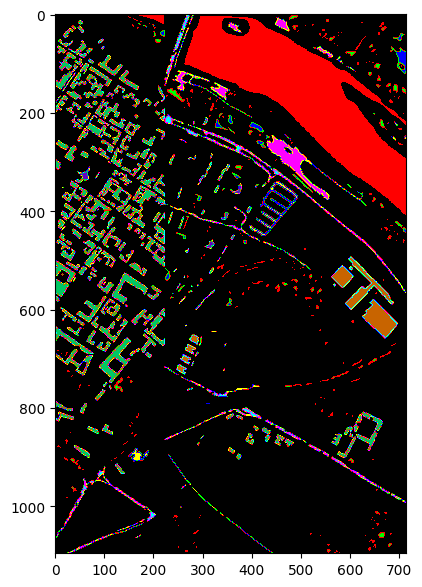

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

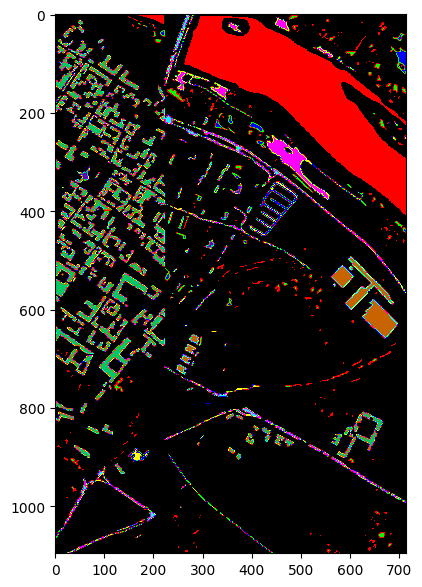

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions2.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)